In [1]:
%load_ext autoreload
%autoreload 2
# %cd /home/ahern/reclone/rf_diffusion_repo_1
%cd /home/ahern/reclone/rf_diffusion_staging

/home/ahern/reclone/rf_diffusion_staging


In [2]:
import sys
import os
for weird_path in [
    '/home/ahern/projects/aa/rf_diffusion_flow/lib/se3_flow_matching',
    '/home/ahern/projects/aa/rf_diffusion_flow',
]:
    if weird_path in sys.path:
        sys.path.remove(weird_path)
# sys.path.append(os.path.join(
#         os.getcwd(),
#         'rf_diffusion',
#     )
# )
sys.path.insert(0, os.path.join(
        os.getcwd(),
        'rf_diffusion',
    )
)

In [3]:
from rf_diffusion.dev import pymol
# pymol.init('http://10.64.100.67:9123')

import glob
import math
import os
from importlib import reload
from rf_diffusion.dev import pymol
from rf_diffusion.dev import analyze
cmd = analyze.cmd

import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rf_diffusion import metrics
from omegaconf import DictConfig, OmegaConf
from rf_diffusion.benchmark import compile_metrics

from rf_diffusion import aa_model
from rf_diffusion.dev import show_bench
from rf_diffusion.dev import show_tip_pa

from rf_diffusion.dev import analyze
from rf_diffusion.dev.show_bench import get_sdata, show_df, add_pymol_name, pseudoatom
from rf_diffusion.dev.analyze import clear
from rf_diffusion.dev.pymol import cmd
from rf_diffusion.dev.benchmark import sorted_value_counts

import tree
import torch
from icecream import ic

from rf_diffusion.dev import benchmark as bm
import functools

# df['guidance'] = df.apply(lambda r: ' '.join(f'{k}:{r[k]}' for k in ['inference.model_runner', 'inference.classifier_free_guidance_scale']), axis=1)
def is_float(element: any) -> bool:
    if element is None: 
        return False
    try:
        float(element)
        return True
    except ValueError:
        return False

def composite_key(cond):
    o = []
    for kv in cond.split():
        k,v = kv.split(':')
        if is_float(v):
            v = float(v)
        o.append(v)
    return tuple(o)

def cmp_val(a, b):
    if a == 'NRBStyleSelfCond' and b != 'NRBStyleSelfCond':
        return -1
    if b == 'NRBStyleSelfCond' and a != 'NRBStyleSelfCond':
        return 1
    if a < b:
        return -1
    if a > b:
        return 1
    return 0

def cmp_cond(conda, condb):
    a = composite_key(conda)
    b = composite_key(condb)
    for i, (aa, bb) in enumerate(zip(a, b)):
        o = cmp_val(aa, bb)
        if o != 0:
            return o
    return 0


def sorted_conds(conds):
    return sorted(conds, key=functools.cmp_to_key(cmp_cond))

[13:54:51] Using backend: pytorch
/opt/dgl/src/runtime/tensordispatch.cc:43: TensorDispatcher: dlopen failed: /home/ahern/.conda/envs/se3/lib/python3.9/site-packages/dgl/tensoradapter/pytorch/libtensoradapter_pytorch_1.13.1.so: cannot open shared object file: No such file or directory


initializing analyze, cmd: <rf_diffusion.dev.pymol.XMLRPCWrapperProxy object at 0x7afde5b4a6a0>


# Analyze finetuned vs basic

In [4]:
raw_df = analyze.combine(
    '/net/scratch/ahern/se3_diffusion/benchmarks/2024-06-30_22-34-23_demo_cfg_center_all_finetune_compare_2/compiled_metrics.csv'
)

In [5]:
df = raw_df
df['finetuned'] = df['inference.ckpt_path'].apply(lambda x: 'finetune' in x)

/tmp/ipykernel_485406/1107184949.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['finetuned'] = df['inference.ckpt_path'].apply(lambda x: 'finetune' in x)


In [6]:
def get_method(r):
    return f'{"finetuned" if r["finetuned"] else "base"}_{str(int(r["epoch"])).zfill(3)}'
df['method'] = df.apply(get_method, axis=1)

In [7]:
sorted_value_counts(df, 'method')

,0
method,
base_063,4000
base_080,4352
finetuned_080,4000
finetuned_102,4224


## Sidechain RMSDs AF2 vs. unideal

In [8]:
data = df
row_var = 'method'
col_var = 'contig_residue'

data["id"] = data.index
y = 'backbone_aligned_allatom_rmsd_af2_unideal'
print(f'{data.shape=}')
data = pd.wide_to_long(data, stubnames=[y], i='id', j='contig_residue', sep="_", suffix='.*_sym_resolved').reset_index()
print(f'{data.shape=}')

data.shape=(16576, 495)
data.shape=(82880, 492)


In [9]:
data = bm.get_least_in_group_single(data, y, groups=['design_id', col_var, row_var])

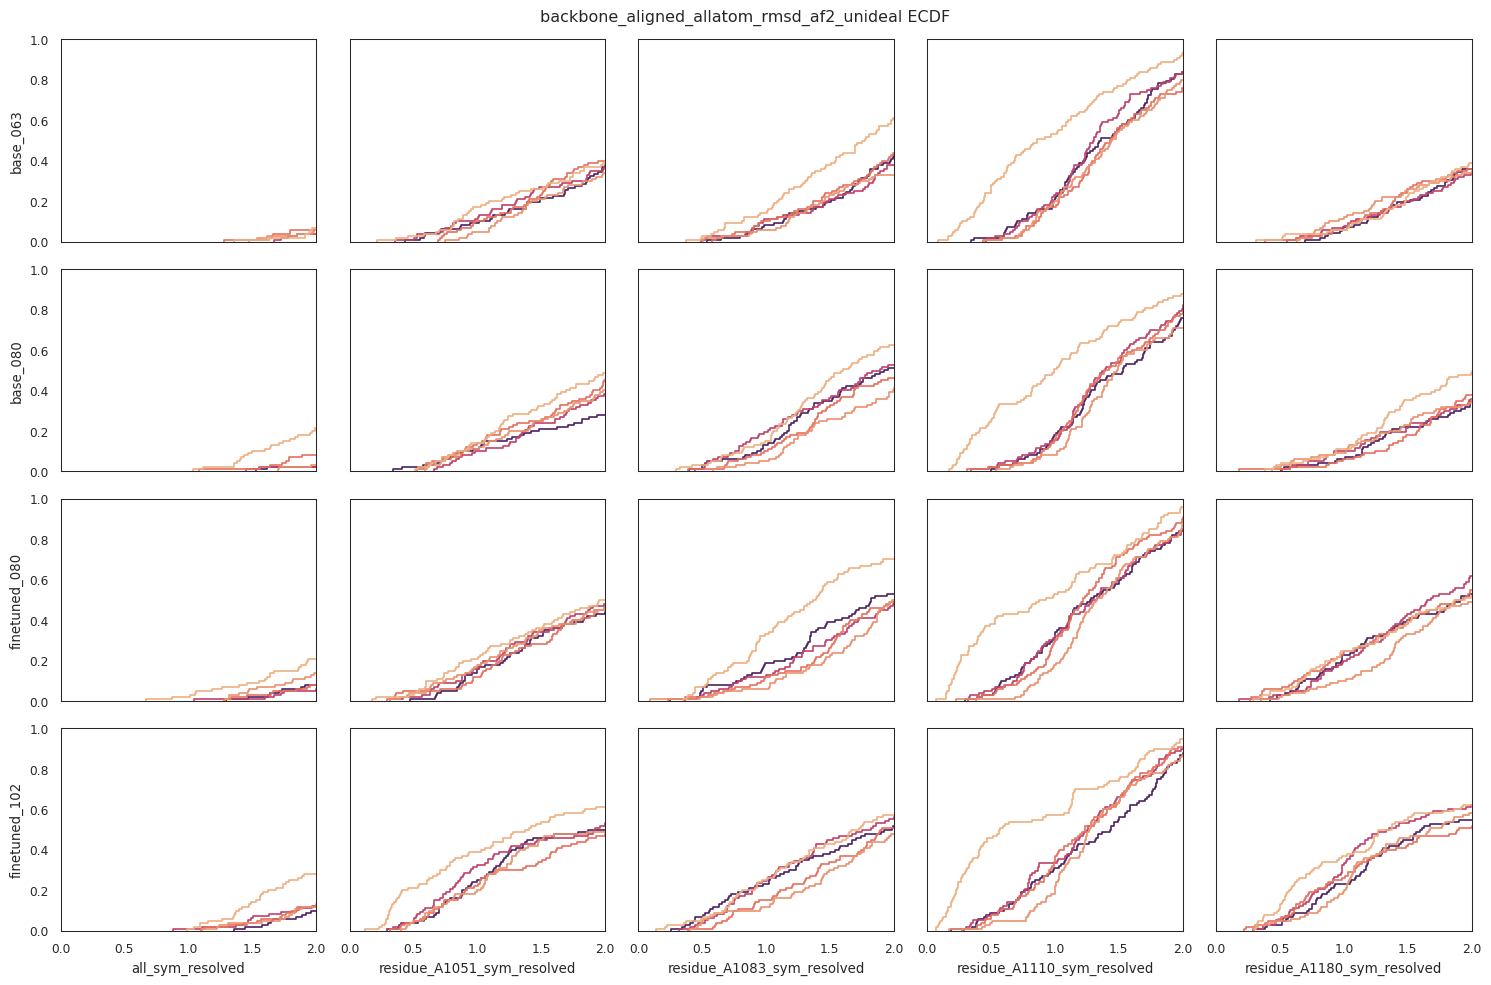

In [10]:
row_vals = sorted(data[row_var].unique())
col_vals = sorted(data[col_var].unique())
fig, axes = plt.subplots(nrows=len(row_vals), ncols=len(col_vals), layout='tight', sharex=True, figsize=(15, 10))
fig.suptitle(f'{y} ECDF')
for i, row_val in enumerate(row_vals):
    for j, col_val in enumerate(col_vals):
        subdata = data[
            (data[row_var] == row_val) &
            (data[col_var] == col_val)
        ]
        subplot_cohort = f'{row_var}: {row_val}, {col_var}: {col_val}'
        # print(f'{subplot_cohort}: {len(subdata)=}')
        # print(sorted_value_counts(subdata, ['inference.classifier_free_guidance_scale']))
        ax = axes[i][j]
        ax = sns.ecdfplot(ax=ax, data=subdata, x=y, hue='inference.classifier_free_guidance_scale', palette='flare')
        # ax.set_title(subplot_cohort)
        ax.set_xlabel(f'{col_val}')
        ax.set_ylabel(f'{row_val}')
        # ax.vlines(1, 0, 1, colors='green')
        ax.legend([],[], frameon=False)
plt.xlim(0, 2)
for ax in axes.flat:
    ax.label_outer()

## Sidechain RMSDs packed vs. unideal

In [11]:
data = df
data["id"] = data.index
y = 'backbone_aligned_allatom_rmsd_packed_unideal'
print(f'{data.shape=}')
data = pd.wide_to_long(data, stubnames=[y], i='id', j='contig_residue', sep="_", suffix='.*_sym_resolved').reset_index()
print(f'{data.shape=}')

data.shape=(16576, 495)
data.shape=(82880, 492)


In [12]:
row_var = 'method'
col_var = 'contig_residue'
data = bm.get_least_in_group_single(data, y, groups=['design_id', col_var, row_var])

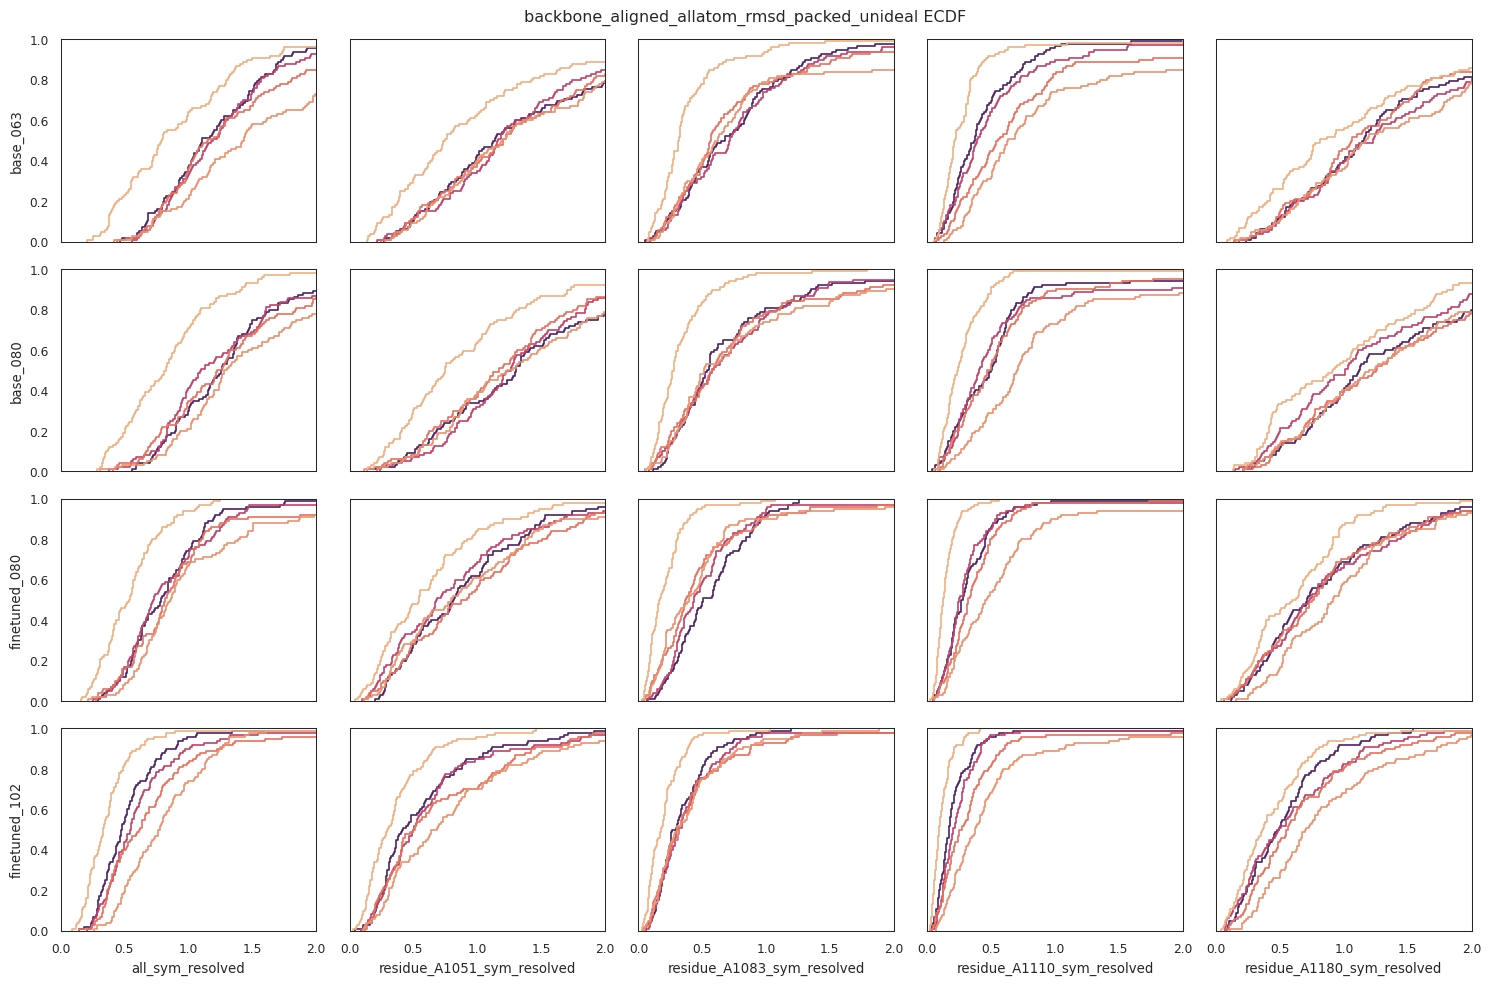

In [13]:
row_vals = sorted(data[row_var].unique())
col_vals = sorted(data[col_var].unique())
fig, axes = plt.subplots(nrows=len(row_vals), ncols=len(col_vals), layout='tight', sharex=True, figsize=(15, 10))
fig.suptitle(f'{y} ECDF')
for i, row_val in enumerate(row_vals):
    for j, col_val in enumerate(col_vals):
        subdata = data[
            (data[row_var] == row_val) &
            (data[col_var] == col_val)
        ]
        subplot_cohort = f'{row_var}: {row_val}, {col_var}: {col_val}'
        # print(f'{subplot_cohort}: {len(subdata)=}')
        # print(sorted_value_counts(subdata, ['inference.classifier_free_guidance_scale']))
        ax = axes[i][j]
        ax = sns.ecdfplot(ax=ax, data=subdata, x=y, hue='inference.classifier_free_guidance_scale', palette='flare')
        # ax.set_title(subplot_cohort)
        ax.set_xlabel(f'{col_val}')
        ax.set_ylabel(f'{row_val}')
        # ax.vlines(1, 0, 1, colors='green')
        ax.legend([],[], frameon=False)
plt.xlim(0, 2)
for ax in axes.flat:
    ax.label_outer()

In [15]:
# The unconditional case is getting ~50% of designs > 0.4A from ideal for finetune_102, this ought to be an easy problem
# and should be better.

## Tyrosine rotamer analysis through torsion angles

In [16]:
from rf_diffusion.dev import show_tip_pa
from rf_diffusion.chemical import ChemicalData as ChemData
from rf2aa import util_module
from rf2aa.chemical import th_dih
xyz_converter = util_module.XYZConverter()

def get_protein_torsion_dictionary():
    d = {}
    for aa_token, aa_3letter in enumerate(ChemData().num2aa[:ChemData().NPROTAAS]):
        d[aa_3letter] = {}
        # aa_token = ChemData().aa2num[aa_3letter]
        token_torsions = ChemData().torsion_indices[aa_token]
        token_atom_names = ChemData().aa2long[aa_token]
        atom_name_by_index = dict(enumerate(token_atom_names))
        for torsion_indices in token_torsions:
            # print(f'{atom_name_by_index=}')
            # print(f'{torsion_indices=}')
            torsion_indices_named = tuple(atom_name_by_index.get(i.item()) if i >= 0 else i for i in torsion_indices)
            d[aa_3letter][torsion_indices_named] = torsion_indices
    return d

protein_torsion_dictionary = get_protein_torsion_dictionary()

def get_named_torsions(
        indep,
        aa_3letter, # TYR
        torsion_4atom, # [" N  "," CA "," CB "," CG "]
):
    aa_token = ChemData().aa2num[aa_3letter]
    torsion_indices = protein_torsion_dictionary[aa_3letter][torsion_4atom]
    assert (torsion_indices >= 0).all()
    # print(f'{indep.seq.shape=}')
    # print(f'{aa_token=}')
    atom_xyz = indep.xyz[indep.seq == aa_token][:, torsion_indices]
    # print(f'{atom_xyz.shape=}')
    cos_sin = th_dih(
        atom_xyz[..., 0, :],
        atom_xyz[..., 1, :],
        atom_xyz[..., 2, :],
        atom_xyz[..., 3, :],
    )
    return torch.atan2(cos_sin[...,1], cos_sin[..., 0])

def get_motif_i(row):
    trb = analyze.get_trb(row)
    return trb[f'con_hal_idx0']

def get_motif_torsion(
        row,
        motif_idx,
        torsion_4atom,
        pdb_getter = analyze.get_diffusion_pdb,
    ):
    # atom_names_by_res_idx = show_tip_pa.get_motif_spec(row, traj=False)
    # motif_resi_selectors, motif_atom_selectors = show_tip_row.get_motif_selectors_2(atom_names_by_res_idx)

    des_pdb = pdb_getter(row)
    indep = aa_model.make_indep(des_pdb)

    # res_idx = list(atom_names_by_res_idx.keys())[motif_idx]
    res_idx = get_motif_i(row)[motif_idx]
    pop = aa_model.make_mask(res_idx, indep.length())
    # pop = F.one_hot(res_idx, indep.length())[None, ...]
    indep, _ = aa_model.slice_indep(indep, pop)

    # print(f'{ChemData().num2aa[indep.seq[0]]=}')

    tyr_tors = get_named_torsions(
        indep,
        ChemData().num2aa[indep.seq[0]],
        torsion_4atom,
    )
    return tyr_tors.item()

In [19]:
n=90
show = df[
    True
    &  (df['mpnn_index'] == 0)
    & (df['inference.classifier_free_guidance_scale'] == 0)
    # & (df['epoch'] == epoch)
]

show = show.groupby("method").sample(n=n, random_state=1)

show['motif_0_tors_des'] = show.apply(lambda x: get_motif_torsion(x, 0, (" N  "," CA "," CB "," CG ")), axis=1)
show['motif_0_tors_af2'] = show.apply(lambda x: get_motif_torsion(x, 0, (" N  "," CA "," CB "," CG "), pdb_getter=analyze.get_af2), axis=1)

show_raw = show

show.shape=(360, 497)
show.shape=(360, 497)


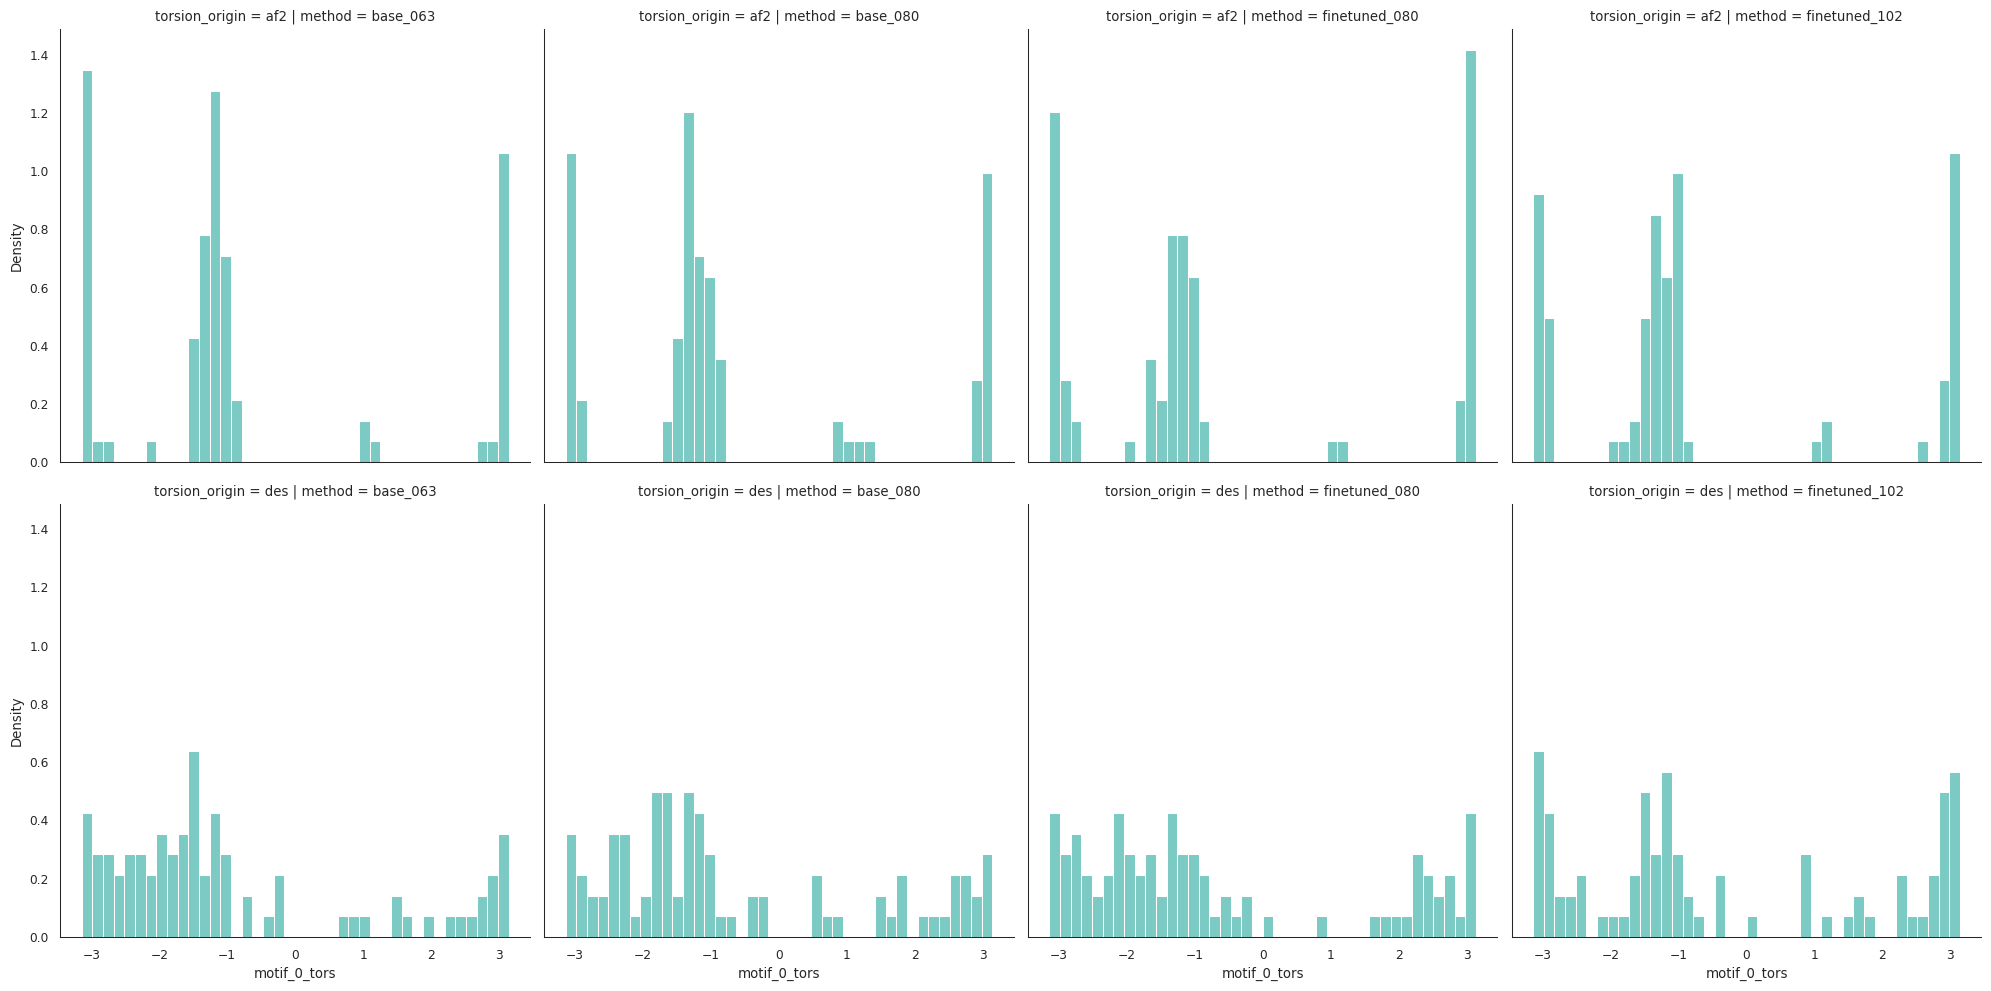

In [20]:
show = show_raw
show["id"] = show.index
print(f'{show.shape=}')
show_wide = pd.wide_to_long(show, stubnames=['motif_0_tors'], i='id', j='torsion_origin', sep="_", suffix='.*').reset_index()
print(f'{show.shape=}')

# def get_row(row):
#     if row['torsion_origin'] == 'af2':
#         return 'af2'
#     else:
#         return row['torsion_origin'] + '_' + str(row['method'])

# show['row'] = show.apply(get_row, axis=1)
# sns.displot(show, x='motif_0_tors', row='row', row_order=sorted(show['row'].unique()), bins=40, stat='density', common_norm=False)

row_var = 'torsion_origin'
col_var = 'method'
sns.displot(show_wide, x='motif_0_tors',
    row=row_var, row_order=sorted(show_wide[row_var].unique()),
    col=col_var, col_order=sorted(show_wide[col_var].unique()),
    bins=40, stat='density', common_norm=False)

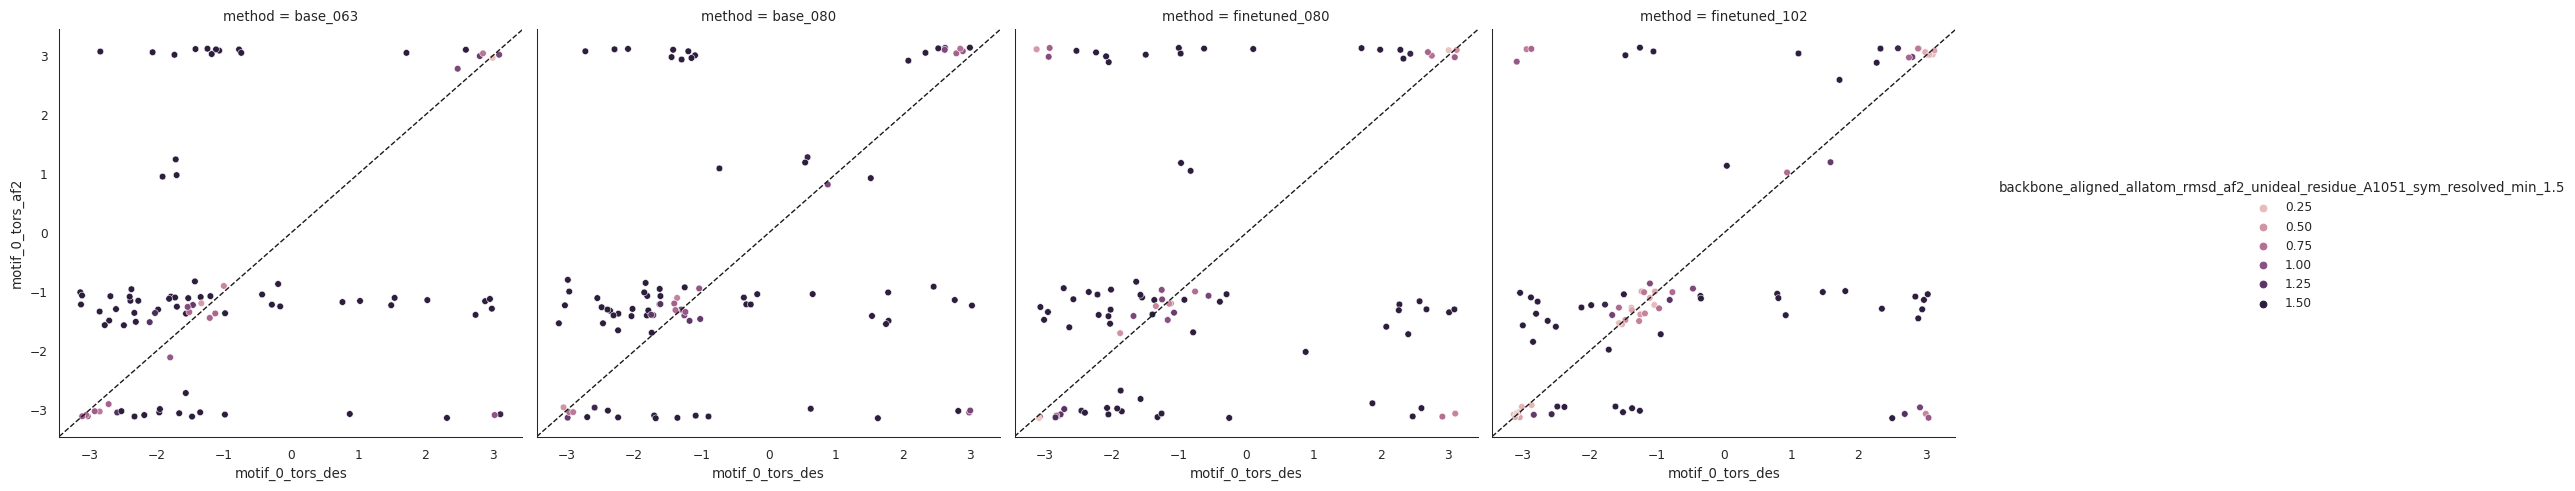

In [21]:
y = 'backbone_aligned_allatom_rmsd_af2_unideal_residue_A1051_sym_resolved'
y_min = 1.5
y_minned = f'{y}_min_{y_min}'
show[y_minned] = np.minimum(show[y], y_min)
g = sns.relplot(show, x='motif_0_tors_des',
    # row=row_var, row_order=sorted(show[row_var].unique()),
    col=col_var, col_order=sorted(show[col_var].unique()),
    y='motif_0_tors_af2',
    hue=y_minned)

def modify_plot(*args, **kwargs):
  """Must take x, y arrays as positional arguments and draw onto the “currently active” 
    matplotlib Axes. Also needs to accept kwargs called color and label.
    We are not using any of these args in this example so just capture them all.
  """
  # The "currently active" matplotlib Axis, unless they decide to pass it to us
  if "ax" in kwargs:
    # Not sure if this is ever used...
    ax = kwargs['ax']
  else:
    ax = plt.gca()
  # Make sure to ax.plot prior to ax.set, for some reason it doesn't work after
  # Oncematplotlib.__version__ >= 3.3 do the following (https://stackoverflow.com/a/73490857/658053)
  # ax.axline((0, 0), slope=1)
  # but the following is similar for earlier versions of matplotlib (https://stackoverflow.com/a/60950862/658053)
  xpoints = ypoints = ax.get_xlim()
  ax.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, scalex=False, scaley=False)

#   ax.set(xscale="log", yscale="log")

g.map(modify_plot)

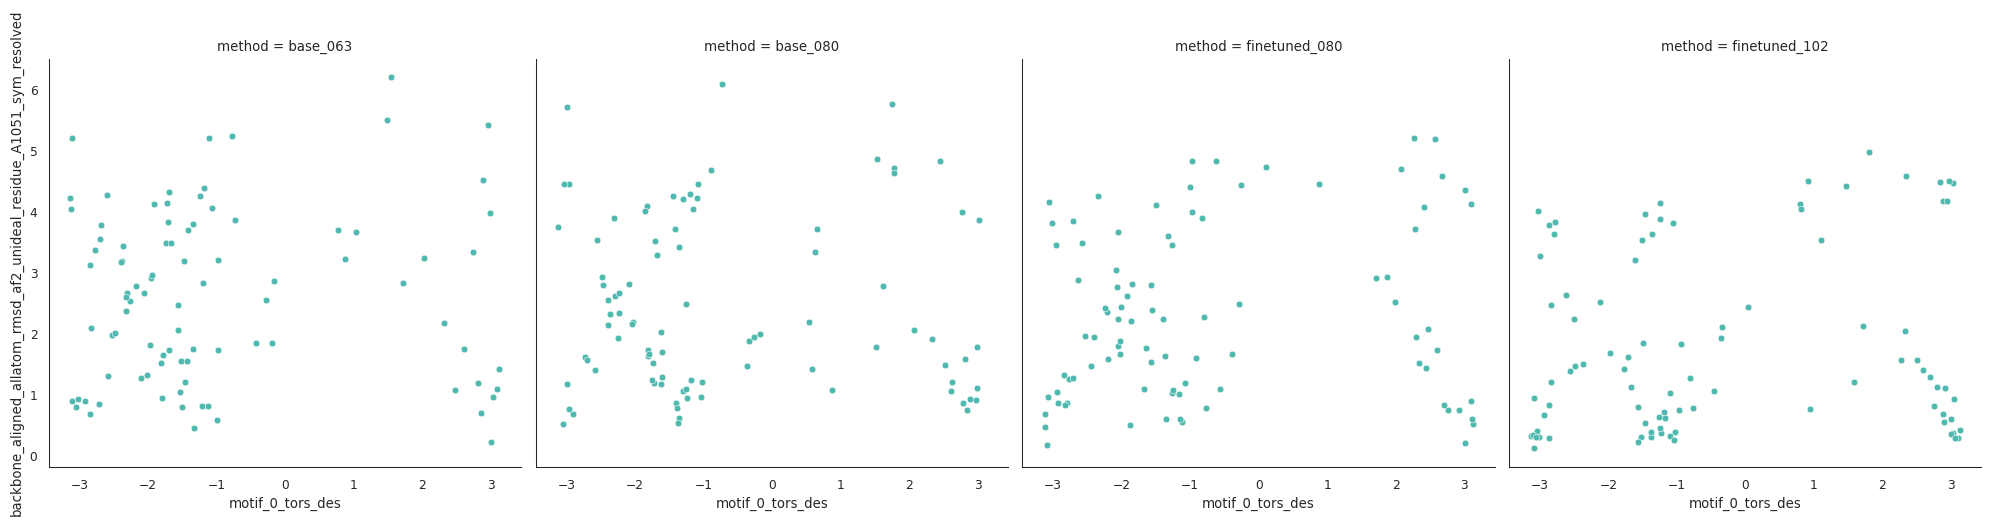

In [22]:
sns.relplot(show, x='motif_0_tors_des',
    # row=row_var, row_order=sorted(show[row_var].unique()),
    col=col_var, col_order=sorted(show[col_var].unique()),
    y='backbone_aligned_allatom_rmsd_af2_unideal_residue_A1051_sym_resolved')